# Image Segmentation pytorch


## Imports

In [1]:
!pip install --upgrade wandb
!wandb login c50979bbf3d2debc97ebbfa9ab39e33acad8354f

import wandb
wandb.init(project="cloud-segmentation")

     |████████████████████████████████| 1.3MB 4.8MB/s 
     |████████████████████████████████| 92kB 32.9MB/s 
     |████████████████████████████████| 102kB 32.8MB/s 
     |████████████████████████████████| 92kB 31.8MB/s 
     |████████████████████████████████| 460kB 43.7MB/s 
     |████████████████████████████████| 71kB 28.3MB/s 
     |████████████████████████████████| 256kB 46.2MB/s 
     |████████████████████████████████| 184kB 28.8MB/s 
  Created wheel for shortuuid: filename=shortuuid-0.5.0-cp36-none-any.whl size=5499 sha256=6b27f7309ad8d670655a412d717832f299be8e8c9fc25383159a509ad26d9355
  Stored in directory: /tmp/.cache/pip/wheels/3f/eb/fd/69e5177f67b505e44acbd1aedfbe44b91768ee0c4cd5636576
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=23c377433f92e8a5756b028c70cf93e997d330613d28186640372c336e26fc9d
  Stored in directory: /tmp/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchd

W&B Run: https://app.wandb.ai/dhananjayraut/cloud-segmentation/runs/rmoli7ln

In [2]:
import os
import gc
import cv2
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tq
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
plt.style.use('bmh')

In [3]:
# seeding function for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return (2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)


def resize_it(x):
    if x.shape != (350, 525):
        x = cv2.resize(x, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
    return x

# Dataset class
class CloudDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame = None,
        datatype: str = "train",
        img_ids: np.array = None,
        transforms=albu.Compose([albu.HorizontalFlip()]), #, AT.ToTensor()
    ):
        self.df = df
        if datatype != "test":
            self.data_folder = f"{img_paths}/train_images_525/train_images_525"
        else:
            self.data_folder = f"{img_paths}/test_images_525/test_images_525"
        self.img_ids = img_ids
        self.transforms = transforms

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = np.transpose(augmented["image"], [2, 0, 1])
        mask = np.transpose(augmented["mask"], [2, 0, 1])
        return img, mask

    def __len__(self):
        return len(self.img_ids)

## Helper functions

In [4]:
# helper functions
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']

def make_mask_T(df, image_label, shape = (1400, 2100), cv_shape = (525, 350),debug=False):
    """
    Create mask based on df, image name and shape.
    """
    df = df.set_index('Image_Label')
    encoded_mask = df.loc[image_label, 'EncodedPixels']
    mask = np.zeros((shape[0], shape[1]), dtype=np.float32)
    if encoded_mask is not np.nan:
        mask = rle_decode(encoded_mask,shape=shape) # original size
    return cv2.resize(mask, cv_shape)

min_size = [10000 ,10000, 10000, 10000]
def post_process_minsize(mask, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions, num = np.zeros(mask.shape), 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions

def show_image(image,figsize=None,title=None):
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
#     else: # crash!!
#         fig = plt.figure()
        
    if image.ndim == 2:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image)
        
    if title is not None:
        plt.title(title)
        
def show_Nimages(imgs,scale=1):

    N=len(imgs)
    fig = plt.figure(figsize=(25/scale, 16/scale))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1, N, i + 1, xticks=[], yticks=[])
        show_image(img)
    plt.show()

def draw_masks(img2,img_mask_list):
    
    img = img2.copy()
    for ii in range(4): # for each of the 4 masks
        color_mask = np.zeros(img2.shape)
        temp_mask = np.ones([img2.shape[0],img2.shape[1]])*127./255.
        temp_mask[img_mask_list[ii] == 0] = 0
        if ii < 3: # use different color for each mask
            color_mask[:,:,ii] = temp_mask
        else:
            color_mask[:,:,0],color_mask[:,:,1],color_mask[:,:,2] = temp_mask,temp_mask,temp_mask # broadcasting to 3 channels
    
        img += color_mask
        
    return img

def draw_convex_hull(mask, mode='convex'):
    
    img = np.zeros(mask.shape)
    contours, hier = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        if mode=='rect': # simple rectangle
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), -1)
        if mode=='convex': # minimum convex hull
            hull = cv2.convexHull(c)
            cv2.drawContours(img, [hull], 0, (255, 255, 255),-1)
        else: # minimum area rectangle
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(img, [box], 0, (255, 255, 255),-1)
    return img/255.

In [5]:
def get_img(x, folder: str = "train_images_525/train_images_525"):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{img_paths}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = "", shape: tuple = (1400, 2100)):
    """
    Decode rle encoded mask.

    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order="F")


def make_mask(df: pd.DataFrame, image_name: str = "img.jpg", shape: tuple = (350, 525)):
    """
    Create mask based on df, image name and shape.
    """
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    df = df[df["im_id"] == image_name]
    for idx, im_name in enumerate(df["im_id"].values):
        for classidx, classid in enumerate(["Fish", "Flower", "Gravel", "Sugar"]):
            mask = cv2.imread(
                "../input/understanding-clouds-resized/train_masks_525/train_masks_525/"
                + classid
                + im_name
            )
            if mask is None:
                continue
            if mask[:, :, 0].shape != (350, 525):
                mask = cv2.resize(mask, (525, 350))
            masks[:, :, classidx] = mask[:, :, 0]
    masks = masks / 255
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype("float32")


def mask2rle(img):
    """
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f"Mask {class_dict[i]}", fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title("Original image", fontsize=fontsize)

        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f"Original mask {class_dict[i]}", fontsize=fontsize)

        ax[1, 0].imshow(image)
        ax[1, 0].set_title("Transformed image", fontsize=fontsize)

        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(
                f"Transformed mask {class_dict[i]}", fontsize=fontsize
            )


def visualize_with_raw(
    image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None
):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title("Original image", fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f"Original mask {class_dict[i]}", fontsize=fontsize)

    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title("Original image", fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f"Raw predicted mask {class_dict[i]}", fontsize=fontsize)

    ax[2, 0].imshow(image)
    ax[2, 0].set_title("Transformed image", fontsize=fontsize)

    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(
            f"Predicted mask with processing {class_dict[i]}", fontsize=fontsize
        )


# sigmoid = lambda x: 1 / (1 + np.exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = (cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1])
    mask = draw_convex_hull(mask.astype(np.uint8))
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = component == c
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5,
            rotate_limit=0,
            shift_limit=0.1,
            p=0.5,
            border_mode=0
        ),
        albu.Resize(320, 640),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(test_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2.0 * intersection.sum() / (img1.sum() + img2.sum())

def stats(path: str):
    """
    prints stats of a submission file.
    """
    df = pd.read_csv(path)
    print("label    empty    Non-empty  total")
    print(f"total      {len([f for f in df.EncodedPixels if f is np.nan])}     {len([f for f in df.EncodedPixels if f is not np.nan])}     {len(df.EncodedPixels)}")
    l = [df.EncodedPixels[t] for t in range(len(df.EncodedPixels)) if df.Image_Label[t].split("_")[-1] == "Fish" ]
    print(f"Fish       {len([f for f in l if f is np.nan])}     {len([f for f in l if f is not np.nan])}     {len(l)}")
    l = [df.EncodedPixels[t] for t in range(len(df.EncodedPixels)) if df.Image_Label[t].split("_")[-1] == "Flower" ]
    print(f"Flower     {len([f for f in l if f is np.nan])}     {len([f for f in l if f is not np.nan])}     {len(l)}")
    l = [df.EncodedPixels[t] for t in range(len(df.EncodedPixels)) if df.Image_Label[t].split("_")[-1] == "Gravel" ]
    print(f"Gravel     {len([f for f in l if f is np.nan])}     {len([f for f in l if f is not np.nan])}     {len(l)}")
    l = [df.EncodedPixels[t] for t in range(len(df.EncodedPixels)) if df.Image_Label[t].split("_")[-1] == "Sugar" ]
    print(f"Sugar      {len([f for f in l if f is np.nan])}      {len([f for f in l if f is not np.nan])}    {len(l)}")

In [6]:
path = "../input/understanding_cloud_organization"
img_paths = "../input/understanding-clouds-resized"
train_on_gpu = torch.cuda.is_available()
SEED = 42
MODEL_NO = 1 # in K-fold
N_FOLDS = 6 # in K-fold
seed_everything(SEED)
os.listdir(path)

['sample_submission.csv', 'test_images', 'train_images', 'train.csv']

## Make split in train test validation

In [7]:
train = pd.read_csv(f"{path}/train.csv")
train["label"] = train["Image_Label"].apply(lambda x: x.split("_")[1])
train["im_id"] = train["Image_Label"].apply(lambda x: x.split("_")[0])

sub = pd.read_csv(f"{path}/sample_submission.csv")
sub["label"] = sub["Image_Label"].apply(lambda x: x.split("_")[1])
sub["im_id"] = sub["Image_Label"].apply(lambda x: x.split("_")[0])

# split data
id_mask_count = (
    train.loc[train["EncodedPixels"].isnull() == False, "Image_Label"]
    .apply(lambda x: x.split("_")[0])
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"index": "img_id", "Image_Label": "count"})
)
ids = id_mask_count["img_id"].values
li = [
    [train_index, test_index]
    for train_index, test_index in StratifiedKFold(
        n_splits=N_FOLDS, random_state=SEED
    ).split(ids, id_mask_count["count"])
]
train_ids, valid_ids = ids[li[MODEL_NO][0]], ids[li[MODEL_NO][1]]
test_ids = sub["Image_Label"].apply(lambda x: x.split("_")[0]).drop_duplicates().values

print(f"training set   {train_ids[:5]}.. with length {len(train_ids)}")
print(f"validation set {valid_ids[:5]}.. with length {len(valid_ids)}")
print(f"testing set    {test_ids[:5]}.. with length {len(test_ids)}")

training set   ['0011165.jpg' '002be4f.jpg' '0031ae9.jpg' '0035239.jpg' '003994e.jpg'].. with length 4620
validation set ['2325e1d.jpg' '23d1c12.jpg' '24dd99c.jpg' '2567ebe.jpg' '2688104.jpg'].. with length 926
testing set    ['002f507.jpg' '0035ae9.jpg' '0038327.jpg' '004f759.jpg' '005ba08.jpg'].. with length 3698


In [8]:
# define dataset and dataloader
num_workers = 2
bs = 8
train_dataset = CloudDataset(
    df=train,
    datatype="train",
    img_ids=train_ids,
    transforms=get_training_augmentation(),
)
valid_dataset = CloudDataset(
    df=train,
    datatype="valid",
    img_ids=valid_ids,
    transforms=get_validation_augmentation(),
)

train_loader = DataLoader(
    train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers
)
valid_loader = DataLoader(
    valid_dataset, batch_size=bs, shuffle=True, num_workers=num_workers
)

## Model Definition

In [9]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, progress=True, num_classes=4)
if train_on_gpu:
    model.cuda()
wandb.watch(model)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:05<00:00, 32.8MB/s]


In [10]:
model # print Model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Loss function definition

In [11]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
    

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return dice + bce

In [12]:
criterion = BCEDiceLoss(eps=1.0, activation=None)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 7, eta_min= current_lr / 100, last_epoch=-1)

In [13]:
def reschedule():
    global epoch, optimizer, scheduler
    if epoch == 7:
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.005)
        current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 6, eta_min= current_lr / 100, last_epoch=-1)
    if epoch == 13:
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.005)
        current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 6, eta_min= current_lr / 100, last_epoch=-1)
    if epoch == 19:
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.002)
        current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 6, eta_min= current_lr / 100, last_epoch=-1)
    if epoch == 25:
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.002)
        current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 6, eta_min= current_lr / 100, last_epoch=-1)

## Training loop

In [14]:
# number of epochs to train the model
n_epochs = 14
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tq(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
        # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = torch.sigmoid(model(data)['out'])
            # calculate the batch loss
            loss = criterion(output, target)
            #print(loss)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            bar.set_postfix(ordered_dict={"train_loss":loss.item()})
            wandb.log({"train_batch_loss": loss.item()})

#     ######################    
#     # validate the model #
#     ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = torch.sigmoid(model(data)['out'])
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice(output.cpu().detach().numpy(),
                            target.cpu().detach().numpy())
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})


    del data, target
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    dice_score = dice_score/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    wandb.log({"Epoch": epoch, "Train loss": train_loss, "Validation loss":valid_loss})
    wandb.log({"Dice Score": dice_score, "Learning Rate":lr_rate_list[-1][0]})
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    
    scheduler.step()
    reschedule()


Epoch: 1  Training Loss: 0.978916  Validation Loss: 0.833877 Dice Score: 0.267795
Validation loss decreased (inf --> 0.833877).  Saving model ...



Epoch: 2  Training Loss: 0.818052  Validation Loss: 0.796012 Dice Score: 0.267810
Validation loss decreased (0.833877 --> 0.796012).  Saving model ...



Epoch: 3  Training Loss: 0.790840  Validation Loss: 0.769939 Dice Score: 0.267928
Validation loss decreased (0.796012 --> 0.769939).  Saving model ...



Epoch: 4  Training Loss: 0.774729  Validation Loss: 0.766593 Dice Score: 0.267917
Validation loss decreased (0.769939 --> 0.766593).  Saving model ...



Epoch: 5  Training Loss: 0.763422  Validation Loss: 0.750968 Dice Score: 0.267742
Validation loss decreased (0.766593 --> 0.750968).  Saving model ...



Epoch: 6  Training Loss: 0.758007  Validation Loss: 0.764238 Dice Score: 0.267803



Epoch: 7  Training Loss: 0.751505  Validation Loss: 0.755453 Dice Score: 0.267840



Epoch: 8  Training Loss: 0.751857  Validation Loss: 0.765321 Dice Score: 0.267796



Epoch: 9  Training Loss: 0.750623  Validation Loss: 0.754897 Dice Score: 0.268048



Epoch: 10  Training Loss: 0.745641  Validation Loss: 0.764125 Dice Score: 0.267594



Epoch: 11  Training Loss: 0.740144  Validation Loss: 0.755344 Dice Score: 0.267871



Epoch: 12  Training Loss: 0.732298  Validation Loss: 0.748563 Dice Score: 0.267983
Validation loss decreased (0.750968 --> 0.748563).  Saving model ...



Epoch: 13  Training Loss: 0.733459  Validation Loss: 0.752815 Dice Score: 0.267888



Epoch: 14  Training Loss: 0.738241  Validation Loss: 0.745992 Dice Score: 0.267927
Validation loss decreased (0.748563 --> 0.745992).  Saving model ...


## Ploting Metrics

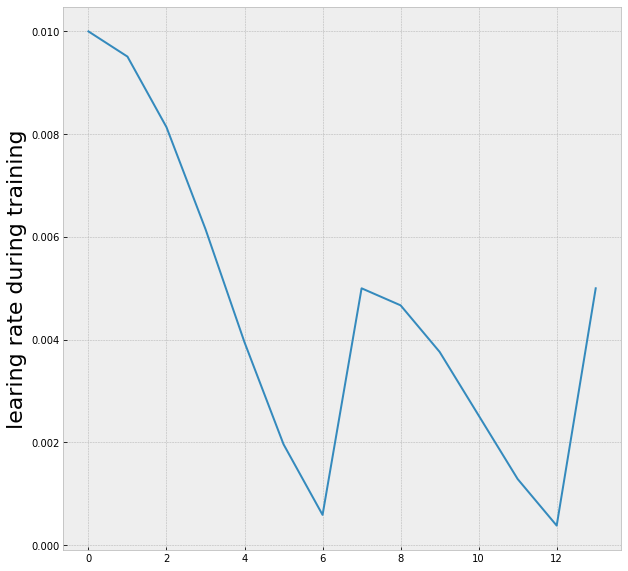

In [15]:
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in lr_rate_list])
plt.ylabel('learing rate during training', fontsize=22)
plt.show()

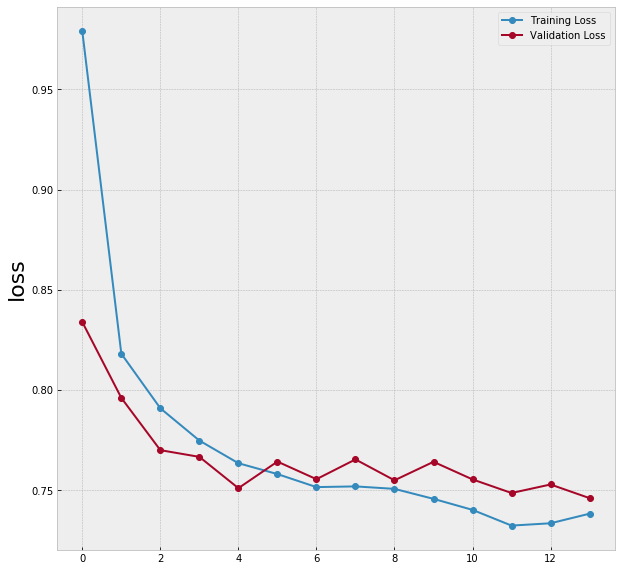

In [16]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

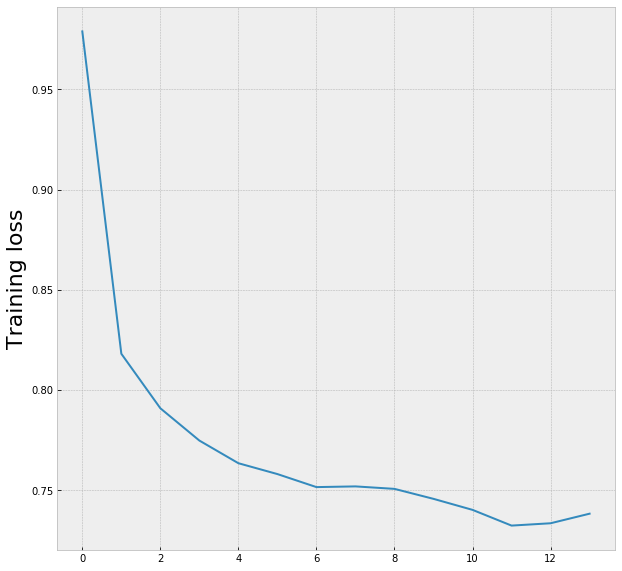

In [17]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list)
plt.ylabel('Training loss', fontsize=22)
plt.show()

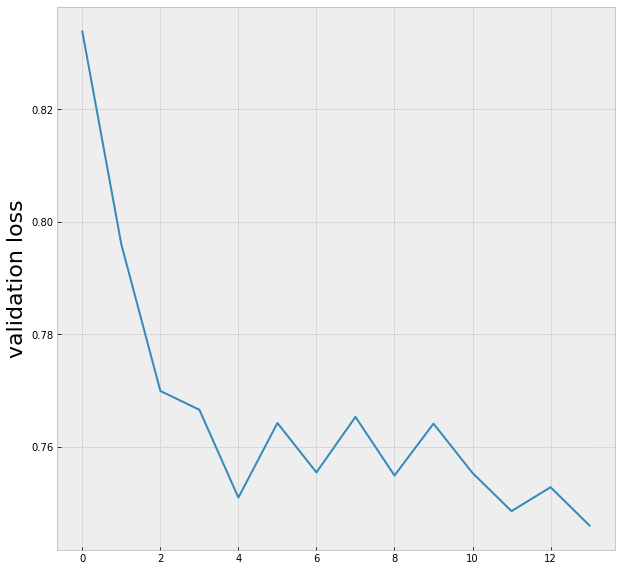

In [18]:
plt.figure(figsize=(10,10))
plt.plot(valid_loss_list)
plt.ylabel('validation loss', fontsize=22)
plt.show()

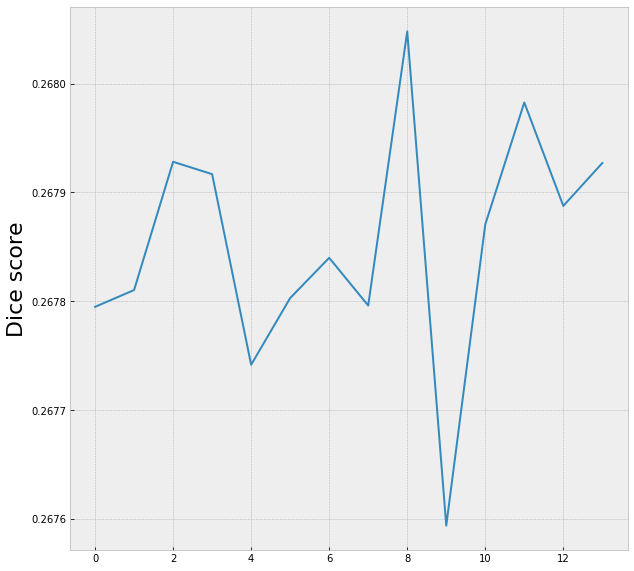

In [19]:
plt.figure(figsize=(10,10))
plt.plot(dice_score_list)
plt.ylabel('Dice score', fontsize=22)
plt.show()

In [20]:
# load best model
model.load_state_dict(torch.load('./model_cifar.pt'))
model.eval();

In [21]:
with torch.no_grad():
    valid_masks = []
    count = 0
    tr = min(len(valid_ids)*4, 2000)
    probabilities = np.zeros((tr, 350, 525), dtype = np.float32)
    for data, target in tq(valid_loader):
        if train_on_gpu:
            data = data.cuda()
        target = target.cpu().detach().numpy()
        outpu = torch.sigmoid(model(data)['out']).cpu().detach().numpy()
        for p in range(data.shape[0]):
            output, mask = outpu[p], target[p]
            for m in mask:
                valid_masks.append(resize_it(m))
            for probability in output:
                probabilities[count, :, :] = resize_it(probability)
                count += 1
            if count >= tr - 1:
                break
        if count >= tr - 1:
            break

## Grid Search for best Threshold

In [22]:
class_params = {}
for class_id in range(4):
    print(class_id)
    attempts = []
    for t in range(0, 100, 5):
        t /= 100
        for ms in [5000, 10000, 20000, 30000, 50000]:
            masks, d = [], []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(probability, t, ms)
                masks.append(predict)
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))
            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    class_params[class_id] = (best_threshold, best_size)

0
    threshold   size      dice
43       0.40  30000  0.610120
48       0.45  30000  0.605255
38       0.35  30000  0.604283
24       0.20  50000  0.599287
53       0.50  30000  0.597298
1
    threshold   size      dice
71       0.70  10000  0.769435
72       0.70  20000  0.766464
67       0.65  20000  0.764534
66       0.65  10000  0.764376
82       0.80  20000  0.763851
2
    threshold   size      dice
67       0.65  20000  0.618461
71       0.70  10000  0.615304
76       0.75  10000  0.614395
72       0.70  20000  0.612283
77       0.75  20000  0.612114
3
    threshold   size      dice
76       0.75  10000  0.600419
66       0.65  10000  0.599126
61       0.60  10000  0.598698
57       0.55  20000  0.597765
71       0.70  10000  0.597229


In [23]:
del masks
del valid_masks
del probabilities
gc.collect()

11591

In [24]:
attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
print(class_params)

{0: (0.4, 30000), 1: (0.7, 10000), 2: (0.65, 20000), 3: (0.75, 10000)}


In [25]:
attempts_df.groupby(['threshold'])['dice'].max()

threshold
0.00    0.259491
0.05    0.478142
0.10    0.527121
0.15    0.540078
0.20    0.560848
0.25    0.571177
0.30    0.575676
0.35    0.585281
0.40    0.593999
0.45    0.591327
0.50    0.594755
0.55    0.597765
0.60    0.598698
0.65    0.599126
0.70    0.597229
0.75    0.600419
0.80    0.592202
0.85    0.581423
0.90    0.559463
0.95    0.508791
Name: dice, dtype: float64

In [26]:
attempts_df.groupby(['size'])['dice'].max()

size
5000     0.594360
10000    0.600419
20000    0.597765
30000    0.580626
50000    0.541176
Name: dice, dtype: float64

In [27]:
attempts_df = attempts_df.sort_values('dice', ascending=False)
attempts_df.head(10)

,threshold,size,dice
76,0.75,10000,0.600419
66,0.65,10000,0.599126
61,0.60,10000,0.598698
57,0.55,20000,0.597765
71,0.70,10000,0.597229
62,0.60,20000,0.595757
52,0.50,20000,0.594755
70,0.70,5000,0.594360
42,0.40,20000,0.593999
81,0.80,10000,0.592202


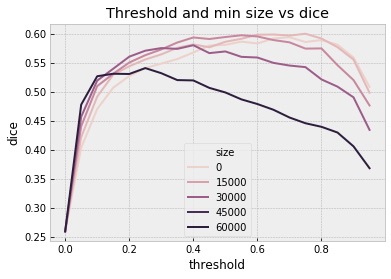

In [28]:
sns.lineplot(x='threshold', y='dice', hue='size', data=attempts_df);
plt.title('Threshold and min size vs dice');

In [29]:
best_threshold = attempts_df['threshold'].values[0]
best_size = attempts_df['size'].values[0]

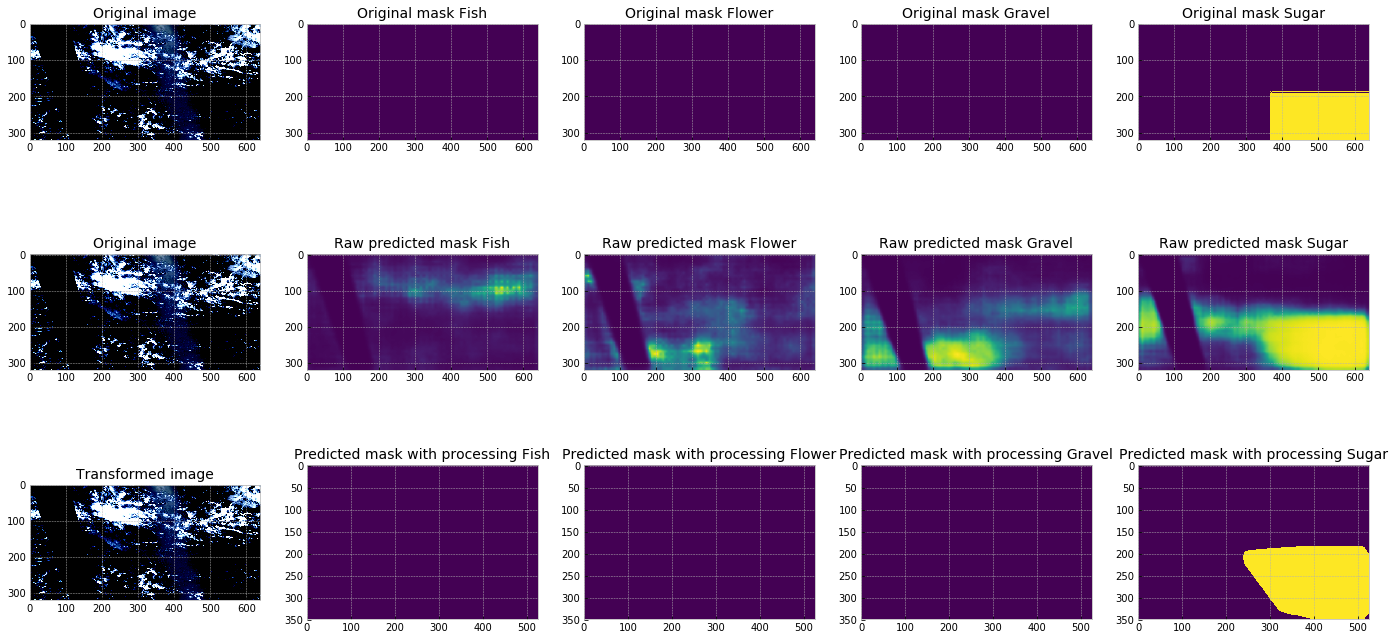

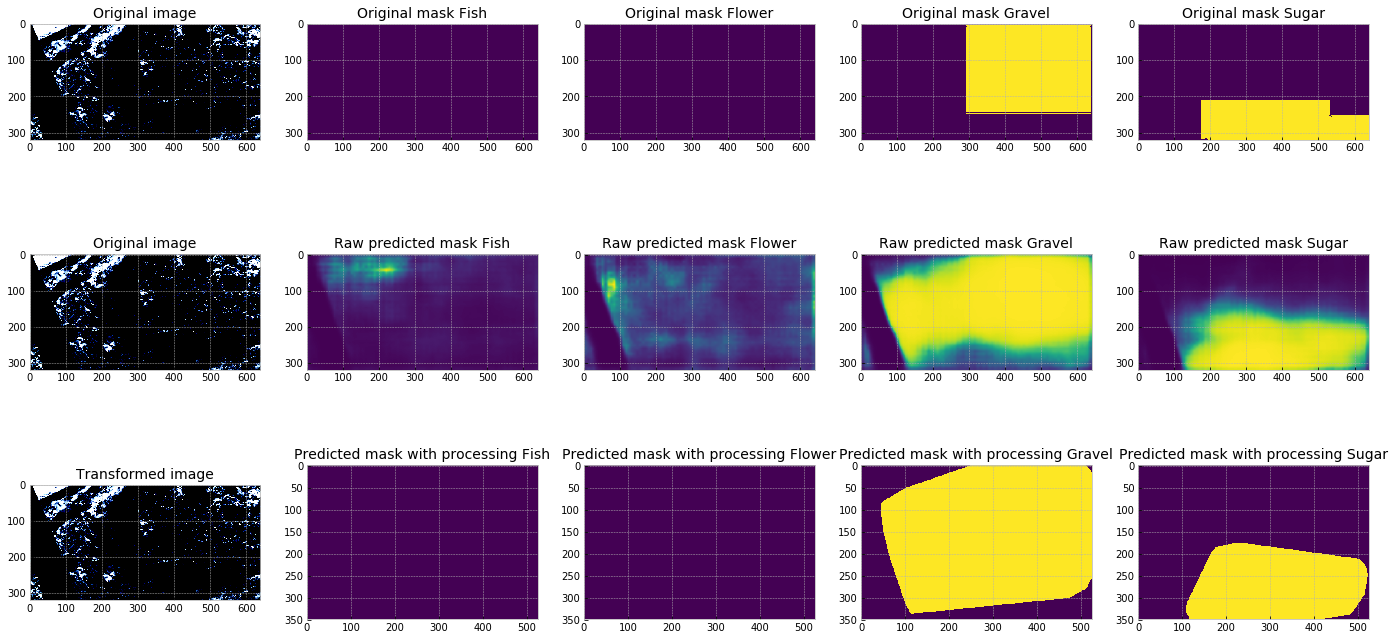

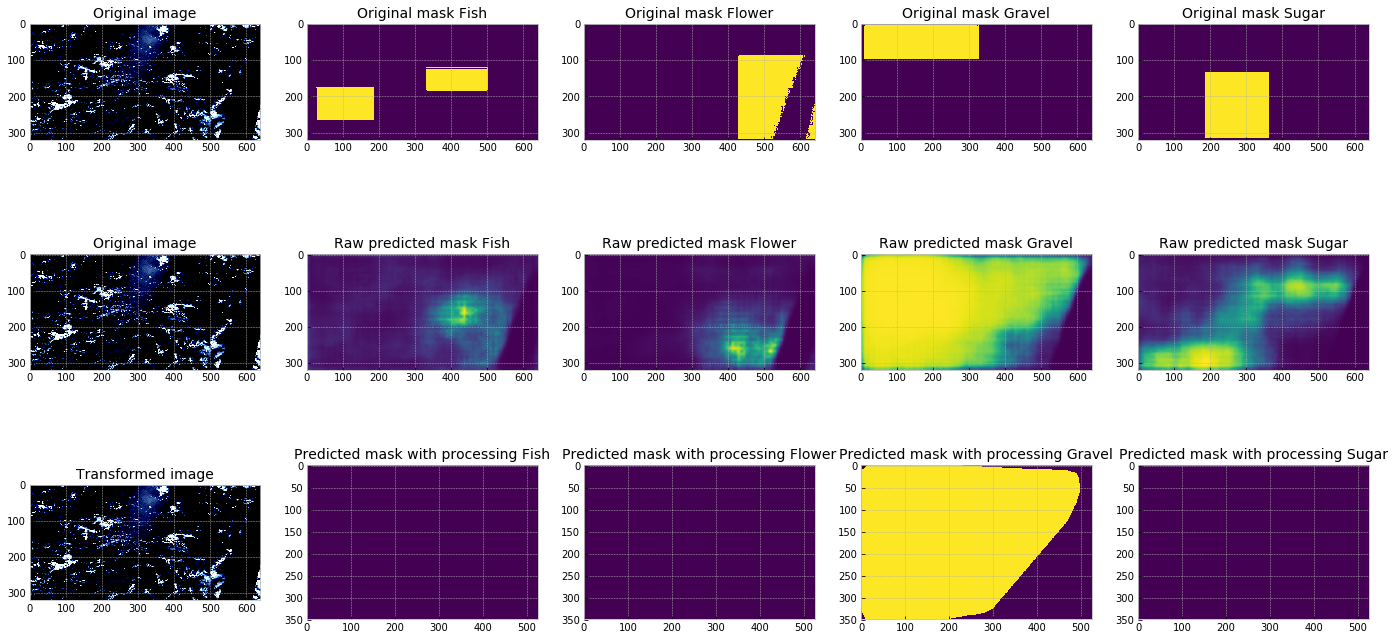

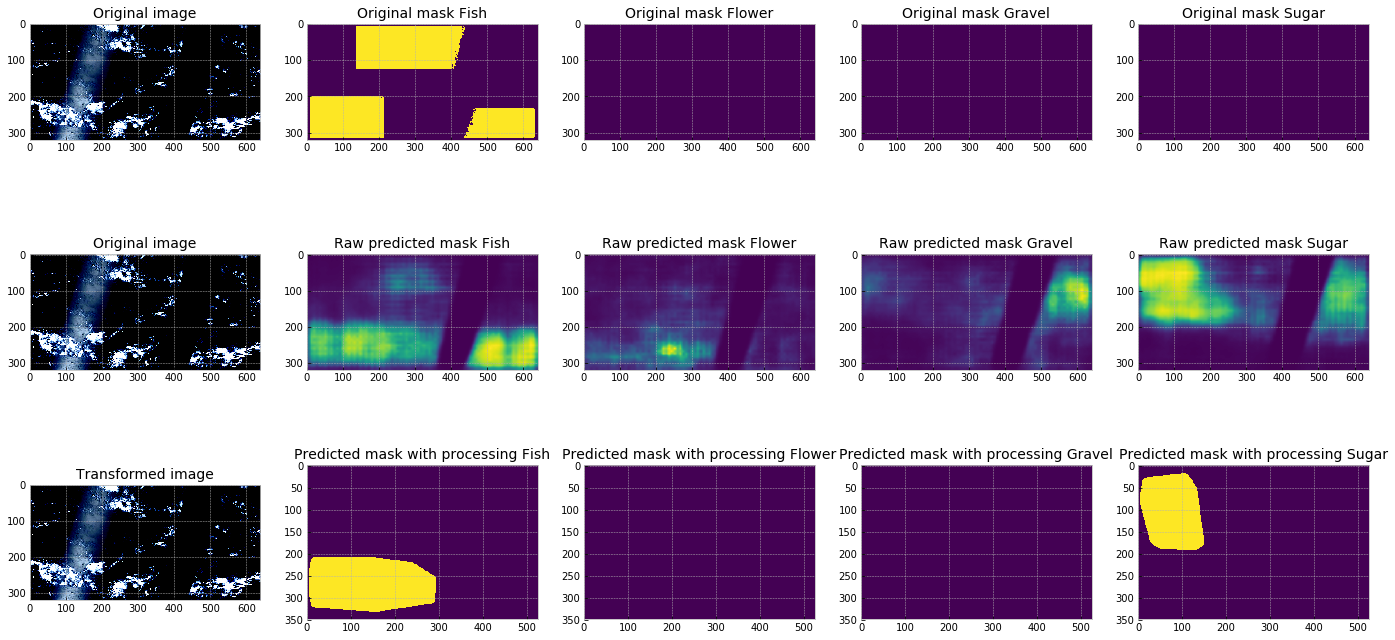

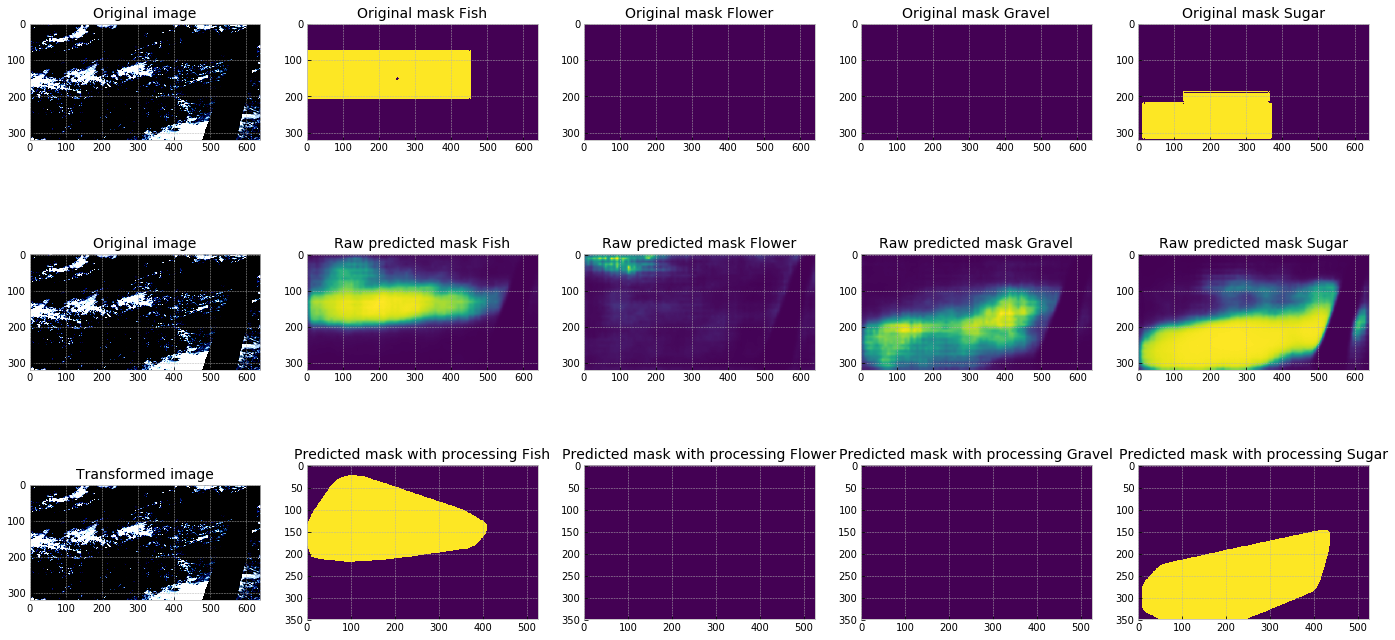

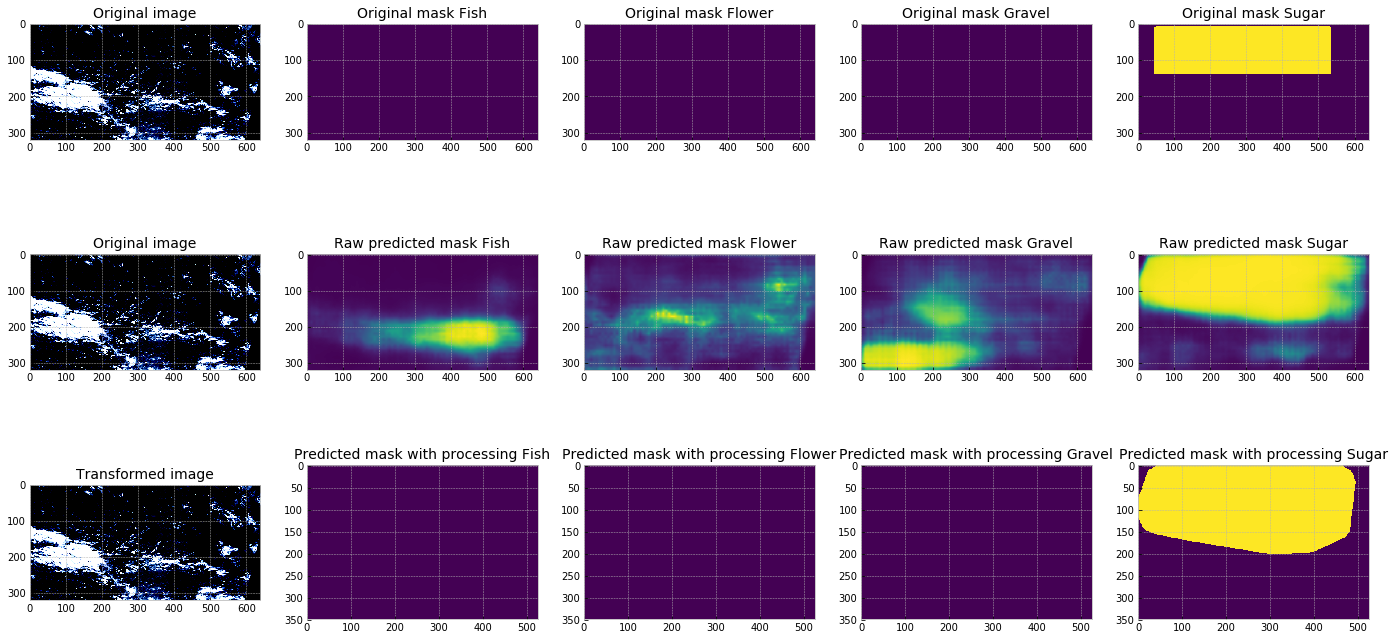

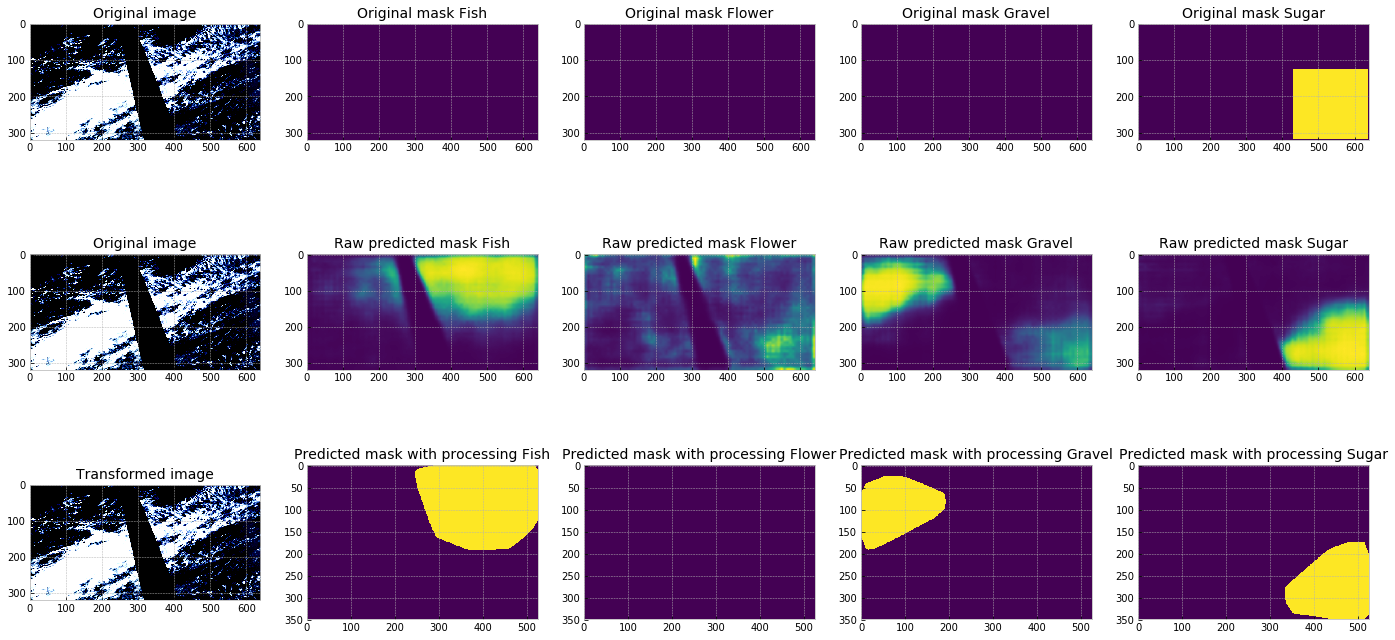

In [30]:
with torch.no_grad():
    for i, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data = data.cuda()
        output = (torch.sigmoid(model(data)['out'])[0]).cpu().detach().numpy()
        image  = data[0].cpu().detach().numpy()
        mask   = target[0].cpu().detach().numpy()
        output = output.transpose(1 ,2, 0)
        image_vis = image.transpose(1, 2, 0)
        mask = mask.astype('uint8').transpose(1, 2, 0)
        pr_mask = np.zeros((350, 525, 4))
        for j in range(4):
            probability = resize_it(output[:, :, j])
            pr_mask[:, :, j], _ = post_process(probability, class_params[j][0], class_params[j][1])

        visualize_with_raw(image=image_vis,
                           mask=pr_mask,
                           original_image=image_vis,
                           original_mask=mask,
                           raw_image=image_vis,
                           raw_mask=output)
        if i >= 6:
            break

In [31]:
torch.cuda.empty_cache()
gc.collect()

222772

In [32]:
test_dataset = CloudDataset(df=sub,
                            datatype='test', 
                            img_ids=test_ids,
                            transforms=get_validation_augmentation())
test_loader = DataLoader(test_dataset, batch_size=4,
                         shuffle=False, num_workers=2)

In [33]:
del train_dataset, train_loader
del valid_dataset, valid_loader
gc.collect()

0

## Prepare Submission

In [34]:
subm = pd.read_csv("../input/understanding_cloud_organization/sample_submission.csv")
pathlist = ["../input/understanding_cloud_organization/test_images/" + i.split("_")[0] for i in subm['Image_Label']]

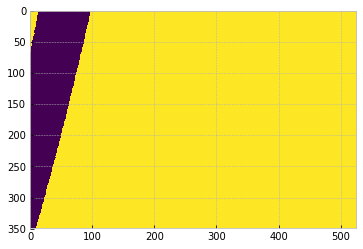

In [35]:
def get_black_mask(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (525,350))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 0], np.uint8)
    upper = np.array([180, 255, 10], np.uint8)
    return (~ (cv2.inRange(hsv, lower, upper) > 250)).astype(int)

plt.imshow(get_black_mask(pathlist[120]))
plt.show()

In [36]:
with torch.no_grad():
    encoded_pixels = []
    image_id , cou , np_saved = 0 , 0, 0
    for data, target in tq(test_loader):
        if train_on_gpu:
            data = data.cuda()
        output = torch.sigmoid(model(data)['out'])
        del data
        for i, batch in enumerate(output):
            for probability in batch:
                probability = resize_it(probability.cpu().detach().numpy())
                predict, num_predict = post_process(probability, class_params[image_id % 4][0], class_params[image_id % 4][1])
                if num_predict == 0:
                    encoded_pixels.append('')
                else:
                    black_mask = get_black_mask(pathlist[cou])
                    np_saved += np.sum(predict)
                    predict = np.multiply(predict, black_mask)
                    np_saved -= np.sum(predict)
                    r = mask2rle(predict)
                    encoded_pixels.append(r)
                cou += 1
                image_id += 1

print(f"number of pixel saved {np_saved}")
sub['EncodedPixels'] = encoded_pixels
sub.to_csv('submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)
stats("./submission.csv")


number of pixel saved 736888.0
label    empty    Non-empty  total
total      8538     6254     14792
Fish       2438     1260     3698
Flower     2148     1550     3698
Gravel     2449     1249     3698
Sugar      1503      2195    3698
